In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm
from matplotlib.colors import ListedColormap
from sklearn.metrics import zero_one_loss
from math import log, isclose, exp
from sklearn.base import BaseEstimator
from copy import deepcopy
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import imageio
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_dataset(filename):
    data = pd.read_csv(filename)
    X = data.values[:, :-1]
    tmp_y = data.values[:, -1]
    y = np.vectorize(lambda t: 1 if t == 'P' else -1)(tmp_y)
    indices = np.arange(y.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [134]:
class SimpleSVM(BaseEstimator):
    def __init__(self):
        self.svm = None
    
    def fit(self, X, y, sample_weight):
        self.svm = LinearSVC(max_iter=20000, C=10 ** 12)
        self.svm.fit(X, y, sample_weight=sample_weight)
        
    def predict(self, X):
        return self.svm.predict(X)

In [135]:
class WeightedVotesPredictor:
    def __init__(self, clfs, clf_weights):
        self.clfs_ = clfs
        self.clf_weights_ = clf_weights
        
    def predict(self, X):
        cnt, dim = X.shape
        answers = np.zeros(cnt)
        for clf, w in zip(self.clfs_, self.clf_weights_):
            answers += w * clf.predict(X)
        return np.sign(answers)

In [136]:
class AdaBoost(BaseEstimator):
    def __init__(self, base_clf, clfs_cnt, verbose=False):
        self.base_clf = base_clf
        self.clfs_cnt = clfs_cnt
        self.clfs_ = None
        self.clf_weights_ = None
        self.verbose = verbose
        
    def fit(self, X, y):
        cnt, dim = X.shape
        sample_weight = np.repeat(1 / cnt, cnt)
        self.clfs_ = [deepcopy(self.base_clf) for _ in range(self.clfs_cnt)]
        self.clf_weights_ = []
        if self.verbose:
            source = tqdm(self.clfs_)
        else:
            source = self.clfs_
        
        for clf in source:
            clf.fit(X, y, sample_weight=sample_weight)
            y_pred = clf.predict(X)
            weighted_error = zero_one_loss(y, y_pred, normalize=False, sample_weight=sample_weight)
#             print(sample_weight)
            if isclose(weighted_error, 0):
                self.clfs_ = [clf]
                self.clf_weights_ = [1]
                break
            elif isclose(weighted_error, 1):
                self.clfs_ = [clf]
                self.clf_weights_ = [-1]
                break
            alpha = 0.5 * log((1 - weighted_error) / weighted_error)
            self.clf_weights_.append(alpha)
            sample_weight = sample_weight * np.exp(-alpha * (y * y_pred))
            sample_weight /= np.sum(sample_weight)

        self.clf_weights_ = np.array(self.clf_weights_)
        self.clfs_ = np.array(self.clfs_)
        
    def predict(self, X):
        cnt, dim = X.shape
        answers = np.zeros(cnt)
        for clf, w in zip(self.clfs_, self.clf_weights_):
            answers += w * clf.predict(X)
        return np.sign(answers)
    
    def getIntermideateClassifiers(self):
        clfs = []
        for i in range(1, self.clfs_.size + 1):
            clfs.append(WeightedVotesPredictor(self.clfs_[0:i], self.clf_weights_[0:i]))
        return np.array(clfs)

In [137]:
def getAdaClf(filename, base_clf, clf_cnt, verbose=True):
    X, y = read_dataset(filename)
    clf = AdaBoost(base_clf, clf_cnt, verbose)
    clf.fit(X, y)
    return clf

In [138]:
def draw(clf, X, y, step):
    stepx = step
    stepy = 0.01
    x_min, y_min = np.amin(X, 0)
    x_max, y_max = np.amax(X, 0)
    x_min -= stepx
    x_max += stepx
    y_min -= stepy
    y_max += stepy
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stepx),
                         np.arange(y_min, y_max, stepy))
    
    mesh_dots = np.c_[xx.ravel(), yy.ravel()]
    zz = clf.predict(mesh_dots)
    zz = np.array(zz).reshape(xx.shape)
    
    plt.figure(figsize=(10, 10))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    x0, y0 = X[y == -1].T
    x1, y1 = X[y == 1].T
    
    plt.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(x0, y0, color='red', s=100)
    plt.scatter(x1, y1, color='blue', s=100)
    plt.show()

In [139]:
chips_X, chips_y = read_dataset("chips.csv")

In [140]:
chips_svm = getAdaClf("chips.csv", SimpleSVM(), 100)

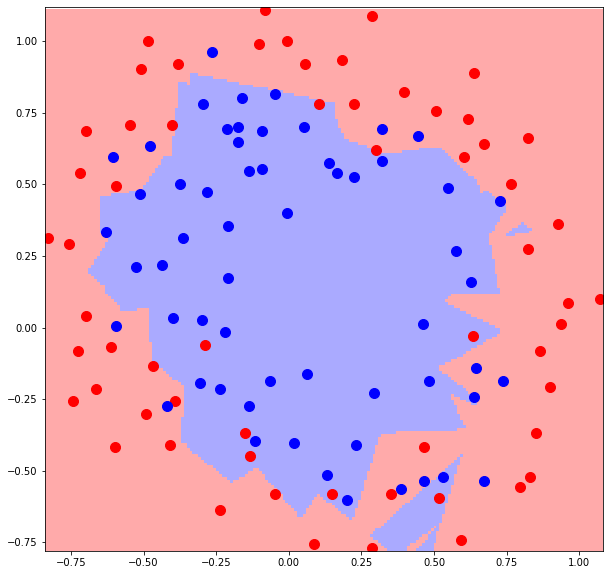

In [141]:
draw(chips_svm, chips_X, chips_y, 0.01)

In [73]:
chips_tree = getAdaClf("chips.csv", DecisionTreeClassifier(max_depth=1), 400)

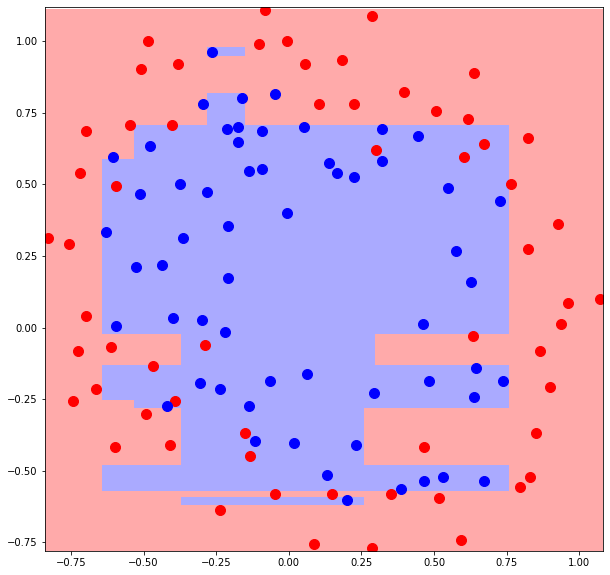

In [12]:
draw(chips_tree, chips_X, chips_y, 0.01)

In [13]:
geyser_X, geyser_y = read_dataset("geyser.csv")

In [15]:
geyser_svm = getAdaClf("geyser.csv", DecisionTreeClassifier(max_depth=1), 80)

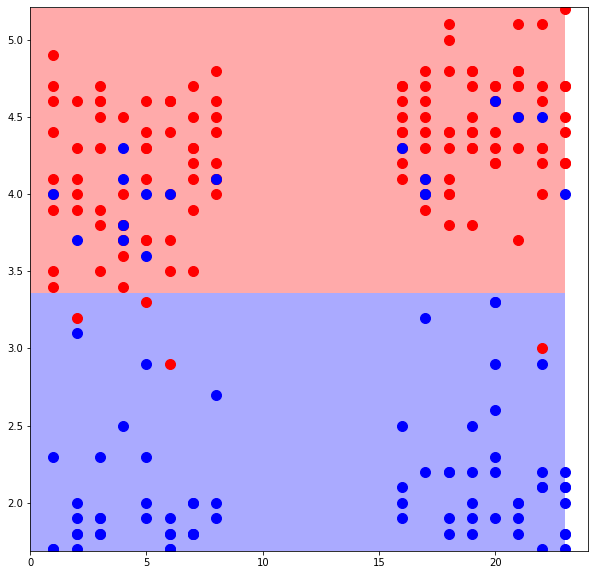

In [37]:
draw(geyser_svm, geyser_X, geyser_y, 1)

In [14]:
geyser_tree = getAdaClf("geyser.csv", DecisionTreeClassifier(max_depth=1), 300)

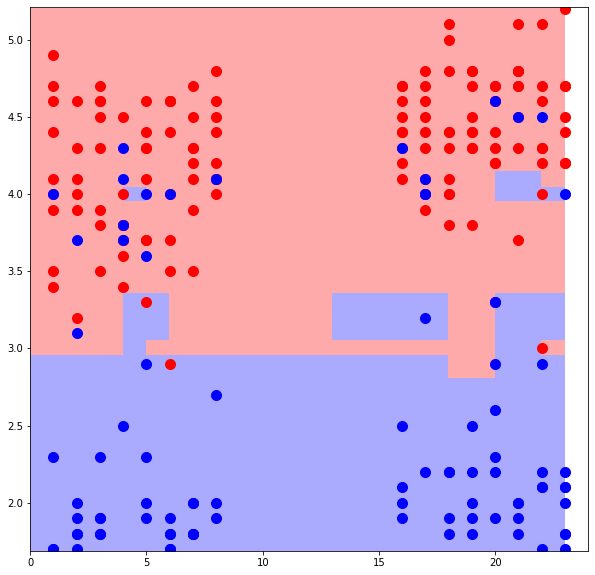

In [16]:
draw(geyser_tree, geyser_X, geyser_y, 1)

In [30]:
def draw_frame(clf, X, y, step):
    fig, ax = plt.subplots(figsize=(10, 10))
    stepx = step
    stepy = 0.01
    x_min, y_min = np.amin(X, 0)
    x_max, y_max = np.amax(X, 0)
    x_min -= stepx
    x_max += stepx
    y_min -= stepy
    y_max += stepy
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stepx),
                         np.arange(y_min, y_max, stepy))
    
    mesh_dots = np.c_[xx.ravel(), yy.ravel()]
    zz = clf.predict(mesh_dots)
    zz = np.array(zz).reshape(xx.shape)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x0, y0 = X[y == -1].T
    x1, y1 = X[y == 1].T
    
    ax.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.scatter(x0, y0, color='red', s=100)
    ax.scatter(x1, y1, color='blue', s=100)
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    return image

def save_gif(ada_clf, X, y, step, name, fps=4):
    frames = [draw_frame(clf, X, y, step)
             for clf in tqdm(ada_clf.getIntermideateClassifiers())]
    imageio.mimsave(name + '.gif', frames, fps=fps)

In [146]:
save_gif(chips_tree, chips_X, chips_y, 0.01, 'chips_tree', 10)

In [143]:
save_gif(chips_svm, chips_X, chips_y, 0.01, 'chips_svm')

In [144]:
save_gif(geyser_svm, geyser_X, geyser_y, 1, 'geyser_svm')

In [147]:
save_gif(geyser_tree, geyser_X, geyser_y, 1, 'geyser_tree', 10)